## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [3]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [3]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [4]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [5]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})
df

,sample_1,sample_2
0,251.019977,1247.176375
1,2045.869879,1022.069818
2,231.577965,32.670294
3,2508.514019,14.483650
4,670.234080,703.524091
...,...,...
995,48.318568,377.383531
996,1095.785684,2086.774816
997,2037.153876,667.253968
998,371.634467,739.595329


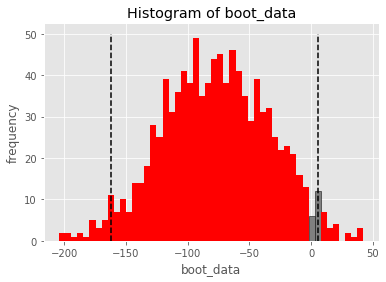

In [11]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [12]:
booted_data["p_value"] # альфа

0.07704553867678232

In [13]:
booted_data["quants"] # ДИ

,0
0.025,-161.943418
0.975,5.328283
